In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm;

# Gather

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# If the image-predictions file does not exist, download it.
image_predictions_file = Path('image-predictions.tsv')
if not(image_predictions_file.exists()):
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv' 
    request = requests.get(url)
    open('image-predictions.tsv', 'wb').write(request.content) 

In [4]:
image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')

In [5]:
# If the file containing the additional data acquired via the Twitter API file does not exist, create it.
dfTwitter_file = Path('tweet_json.txt')
if not(dfTwitter_file.exists()):
    consumer_key = '####################'
    consumer_secret = '####################'
    access_token = '####################'
    access_token_secret= '####################'

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)
    
    all_ids = twitter_archive.tweet_id.values
    
    failed = []
    with open('tweet_json.txt', 'w') as outfile:
        for tweet_id in all_ids:
            try:
                tweet = api.get_status(tweet_id, tweet_mode="extended")
                print("Acquired tweet with ID: ", tweet_id)
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError:
                print("Could not acquire tweet with ID: ", tweet_id)
                failed.append(tweet_id)
                pass

In [6]:
# Load in the additional Twitter data
filename = 'tweet_json.txt'
dfTwitter = pd.DataFrame(columns = {'tweet_id', 'retweet_count', 'favorite_count'})
with open(filename) as the_file:
    for line in the_file:
        status = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        the_row = [tweet_id, retweet_count, favorite_count]
        #print(the_row)
        df_row = pd.DataFrame([the_row], columns = ['tweet_id', 'retweet_count', 'favorite_count'])
        dfTwitter = dfTwitter.append(df_row)
dfTwitter = dfTwitter.reset_index(drop = True)

In [7]:
# I prefer to keep a copy of the originals and then clean the already imported dataframes 
twitter_archive_original = twitter_archive.copy()
image_predictions_original = image_predictions.copy()
dfTwitter_original = dfTwitter.copy()

# Assess

`twitter_archive`
---------------

### Visual assessment:

In [8]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [9]:
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1229,713761197720473600,NaN,NaN,2016-03-26 16:15:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Piper. She would really like that tenn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713761197...,12,10,Piper,None,None,None,None


In [10]:
[text for text in twitter_archive.source][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

The `source` column is in html format and not easily usable for analysis  
We should extract two variables from the sources column: html address & name of page (Quality issues).    
Then store these values in two new columns. 

### Programmatic assessment:

In [11]:
twitter_archive.shape

(2356, 17)

In [12]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


Why is there a rating numerator of 1776? Let's have a look at the related text...

In [13]:
twitter_archive.rating_numerator.max()
max_rating_row = twitter_archive[twitter_archive.rating_numerator == twitter_archive.rating_numerator.max()]
[text for text in max_rating_row.text]

["This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"]

Checking the associated picture, this is an amusing reference to the date of the United States Declaration of Independence.
We should remove this item before analysis.

In [14]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

We need to change to "Timestamp" column to datetime datatype (quality) and split into "time" and "date" columns. (Tidiness issue).

We need to make a single column "stage" and record the stage of dog. Then, drop the doggo, floofer, pupper & puppo columns. (Tidiness issue).

Retweets should be removed ( https://knowledge.udacity.com/questions/79100 ). Afterwards, the retweets columns and associated columns should be removed.

Replies to other users should be removed as the "Project Motivation" states that we "only want original ratings".  (See also: https://knowledge.udacity.com/questions/79100 ). 



In [15]:
(twitter_archive.rating_denominator != 10).value_counts()

False    2333
True       23
Name: rating_denominator, dtype: int64

We're expecting all the denominators to be 10. Something isn't right. What?

In [16]:
for text in (twitter_archive[['text']][twitter_archive.rating_denominator != 10].values):
    print(text)

["@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"]
['@docmisterio account started on 11/15/15']
['The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd']
['Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx']
['RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…']
['Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE']
['After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ']
['Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv']
['Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a']
['This

Values that are not ratings (e.g., some are dates) have ended up in the denominator column. As there are only 23 incorrect items, these rows can just be removed.

`image_predictions`
---------------

In [17]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [18]:
image_predictions.shape

(2075, 12)

In [19]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Are any images not identified as dogs?

In [20]:
len(image_predictions[(image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == False)])

324

In [21]:
image_predictions[(image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


These should be removed.

In [22]:
len(image_predictions[~((image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == False))])

1751


`dfTwitter`
---------------

In [23]:
dfTwitter

,tweet_id,favorite_count,retweet_count
0,892420643555336193,34636,7232
1,892177421306343426,30021,5419
2,891815181378084864,22599,3579
3,891689557279858688,37886,7435
4,891327558926688256,36162,7988
...,...,...,...
2323,666049248165822465,92,37
2324,666044226329800704,252,119
2325,666033412701032449,103,38
2326,666029285002620928,116,41


In [24]:
dfTwitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2328 non-null   object
 1   favorite_count  2328 non-null   object
 2   retweet_count   2328 non-null   object
dtypes: object(3)
memory usage: 54.7+ KB


We want to merge `dfTwitter` with `twitter_archive` using `tweet_id` as the key, so we must ensure the datatype for this column is consistent across the DataFrames, i.e., make them all int64. The other columns of `dfTwitter` will be used for data analysis. So these should also be changed to int64 format.

## To do list based on assessment
### Quality
#### `twitter_archive` table
1. Retweets should be removed. 
2. Remove retweets columns and associated columns.
3. Replies to other users should be removed. 
4. `source` column:  
i) Extract two variables from sources column: html address, name of page (quality)    
ii) Store these values in two new columns (tidiness)  
5. Change "Timestamp" column to datetime data type (quality); split into "time" and "date" columns (tidiness)
6. Decide which of the four variables (doggo, floofer, pupper &	puppo) a dog actually belongs to (quality). Make a single column "stage" and record stage of dog; Drop doggo, floofer, pupper &	puppo columns (tidiness) 
7. Remove rows where the rating_denominator is not 10
8. Remove rating_denominator column as the number is always 10. Rename rating_numerator column.
9. Remove the row with the 1776 rating.

#### `image_predictions` table
1. Remove any image predictions that aren't dogs

#### `dfTwitter` table
1. Datatype of `tweet_id`, `retweet_count` and `favorite_count` in `dfTwitter` needs to be int64 
                                                                   
### Tidiness
1. There are two variables in `source` column in `twitter_archive`: html address, name of page. Make two columns to contain these
2. Merge the cleaned `dfTwitter` and  `twitter_archive` together and save as `twitter_archive_master.csv`
3. The cleaned `image_predictions` dataframe should be saved separately in order to conform to Wickham, 2014: "3. Each observational unit forms a table." 


# Clean

`twitter_archive`
---------------

##### 1a) Define

Retweets should be removed. Reference: https://knowledge.udacity.com/questions/79100

##### 1b) Code

In [25]:
twitter_archive = (twitter_archive[~twitter_archive.retweeted_status_id.notna()])

##### 1c) Test

In [26]:
len( twitter_archive[twitter_archive.retweeted_status_id.notna()] )

0

##### 2a) Define

Remove retweets columns and associated columns

##### 2b) Code

In [27]:
twitter_archive.drop('retweeted_status_id', axis = 1, inplace = True)
# Remove associated columns
twitter_archive.drop('retweeted_status_timestamp', axis = 1, inplace = True)
twitter_archive.drop('retweeted_status_user_id', axis = 1, inplace = True)

C:\Users\renju\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### 2c) Test

In [28]:
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


##### 3a) Define

Replies to other users should be removed. Reference: https://knowledge.udacity.com/questions/79100 . Also, "Project Motivation" states: "You only want original ratings".

##### 3b) Code

In [29]:
twitter_archive = (twitter_archive[~twitter_archive.in_reply_to_status_id.notna()])
twitter_archive.drop('in_reply_to_status_id', axis = 1, inplace = True)
# Remove associated column(s)
twitter_archive.drop('in_reply_to_user_id', axis = 1, inplace = True)

##### 3c) Test

In [30]:
twitter_archive.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


##### 4a) Define

i) Extract two variables from sources column: html address, name of page (Quality)  
ii) Store these values in two new columns (Tidiness)

##### 4b) Code

In [31]:
unique_sources = twitter_archive.source.unique()
unique_sources

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

There are only two sets of 4 distinct values. The first set of 4 values are:

In [32]:
unique_source_locs = [unique_source.split("\"")[1] for unique_source in unique_sources]
unique_source_locs

['http://twitter.com/download/iphone',
 'http://twitter.com',
 'http://vine.co',
 'https://about.twitter.com/products/tweetdeck']

The second set of 4 values are:

In [33]:
unique_source_names = [unique_source.split(">")[1][:-3] for unique_source in unique_sources]
unique_source_names

['Twitter for iPhone',
 'Twitter Web Client',
 'Vine - Make a Scene',
 'TweetDeck']

In [34]:
# Make two new columns & remove original column
twitter_archive['source_name'] = twitter_archive.source
twitter_archive['source_location'] = twitter_archive.source
twitter_archive.drop('source', axis = 1, inplace = True)

In [35]:
for i in range(len(unique_sources)) :
    twitter_archive['source_location'] = twitter_archive['source_location'].replace(unique_sources[i], unique_source_locs[i])
    twitter_archive['source_name'] = twitter_archive['source_name'].replace(unique_sources[i], unique_source_names[i])

##### 4c) Test

In [36]:
twitter_archive.source_location.unique()

array(['http://twitter.com/download/iphone', 'http://twitter.com',
       'http://vine.co', 'https://about.twitter.com/products/tweetdeck'],
      dtype=object)

In [37]:
twitter_archive.source_name.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

In [38]:
twitter_archive.head(1)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_name,source_location
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone


##### 5a) Define
Change "Timestamp" column to datetime data type (Quality) & split columns into "Time" and "Date" columns (Tidiness).
Drop "Timestamp" column.

##### 5b) Code

In [39]:
twitter_archive['timestamp'] = pd.to_datetime(twitter_archive.timestamp.str[:-5])

In [40]:
twitter_archive['time'] = [ val.time() for val in twitter_archive['timestamp'] ]

In [41]:
twitter_archive['date'] = [ val.date() for val in twitter_archive['timestamp'] ]

In [42]:
twitter_archive = twitter_archive.drop('timestamp', axis = 1)

##### 5c) Test

In [43]:
twitter_archive.head()

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_name,source_location,time,date
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,16:23:56,2017-08-01
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,00:17:27,2017-08-01
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,00:18:03,2017-07-31
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,15:58:51,2017-07-30
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,16:00:24,2017-07-29


##### 6a) Define

Decide which of the four variables (doggo, floofer, pupper &puppo) a dog actually belongs to (quality).     
Make a single column "stage" and record stage of dog; Drop doggo, floofer, pupper &	puppo columns (tidiness).

##### 6b) Code

In [44]:
twitter_archive['stage'] = [val for val in (twitter_archive.doggo+twitter_archive.floofer+twitter_archive.pupper+twitter_archive.puppo)]

In [45]:
twitter_archive['stage'] = twitter_archive['stage'].str.replace('NoneNoneNoneNone', 'Not recorded')

In [46]:
twitter_archive['stage'] = twitter_archive['stage'].str.replace('None', '')

In [47]:
twitter_archive['stage'].value_counts()

Not recorded    1761
pupper           221
doggo             72
puppo             23
doggopupper        9
floofer            9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

Force a choice of 1 of the 4 stages according to my understanding of ["The Dogtionary"]:(https://classroom.udacity.com/nanodegrees/nd002/parts/af503f34-9646-4795-a916-190ebc82cb4a/modules/86c36b91-055f-4970-8462-864f332c2ebb/lessons/a8085857-3e28-4fc7-aeb8-da64ccbc2e20/concepts/28d4643b-3785-4700-bdee-4e5fc9963576)

In [48]:
twitter_archive['stage'] = twitter_archive['stage'].str.replace('doggofloofer', 'floofer');
twitter_archive['stage'] = twitter_archive['stage'].str.replace('doggopuppo', 'puppo');
twitter_archive['stage'] = twitter_archive['stage'].str.replace('doggopupper', 'pupper');

In [49]:
twitter_archive.drop(['doggo','floofer','pupper','puppo'], axis = 1, inplace = True)

##### 6c) Test

In [50]:
twitter_archive['stage'].value_counts()

Not recorded    1761
pupper           230
doggo             72
puppo             24
floofer           10
Name: stage, dtype: int64

In [51]:
twitter_archive.sample()

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,name,source_name,source_location,time,date,stage
1966,673343217010679808,IT'S SO SMALL ERMERGERF 11/10 https://t.co/dNU...,https://twitter.com/dog_rates/status/673343217...,11,10,None,Twitter for iPhone,http://twitter.com/download/iphone,03:28:27,2015-12-06,Not recorded


##### 7a) Define

Remove rows where the rating_denominator is not 10.

##### 7b) Code

In [52]:
len(twitter_archive[(twitter_archive.rating_denominator != 10)])

17

In [53]:
twitter_archive = twitter_archive[~(twitter_archive.rating_denominator != 10)]

##### 7c) Test

In [54]:
(twitter_archive.rating_denominator != 10).value_counts()

False    2080
Name: rating_denominator, dtype: int64

##### 8a) Define

Remove rating_denominator column as the number is always 10. Rename rating_numerator column to remind us of that the denominator equals 10.

##### 8b) Code

In [55]:
twitter_archive = twitter_archive.drop('rating_denominator', axis = 1)
twitter_archive = twitter_archive.rename(columns = {'rating_numerator' : 'rating_out_of_10'})

##### 8c) Test

In [56]:
twitter_archive.head()

,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,Twitter for iPhone,http://twitter.com/download/iphone,16:23:56,2017-08-01,Not recorded
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,Twitter for iPhone,http://twitter.com/download/iphone,00:17:27,2017-08-01,Not recorded
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,Twitter for iPhone,http://twitter.com/download/iphone,00:18:03,2017-07-31,Not recorded
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,Twitter for iPhone,http://twitter.com/download/iphone,15:58:51,2017-07-30,Not recorded
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,Twitter for iPhone,http://twitter.com/download/iphone,16:00:24,2017-07-29,Not recorded


##### 9a) Define

Remove the row with the 1776 rating

##### 9b) Code

In [57]:
twitter_archive = twitter_archive[~(twitter_archive.rating_out_of_10 == twitter_archive.rating_out_of_10.max())]

##### 9c) Test

In [58]:
twitter_archive.rating_out_of_10.max()

420

## _Iteration_

The fact that the rating of 420 still seems to be an outlier led to us iterating through the Assess, Clean, Analyse cycle and discovering that it was worthwhile to fix a few more outliers:

##### Define
The image associated with the rating of 420 shows Snoop Dogg, so remove!

In [59]:
print([text for text in twitter_archive[ twitter_archive.rating_out_of_10 == 420].text])
twitter_archive[ twitter_archive.rating_out_of_10 == 420]

['After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY']


,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage
2074,670842764863651840,After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420,None,Twitter for iPhone,http://twitter.com/download/iphone,05:52:33,2015-11-29,Not recorded


##### Code

In [60]:
twitter_archive = twitter_archive[~(twitter_archive.rating_out_of_10 == 420)]

##### Test

In [61]:
any(twitter_archive.rating_out_of_10 == 420)

False

##### Define
Fix the next outlier, if required

In [62]:
twitter_archive.rating_out_of_10.max()

75

In [63]:
print([text for text in twitter_archive[ twitter_archive.rating_out_of_10 == 75].text])
twitter_archive[ twitter_archive.rating_out_of_10 == 75]

["This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"]


,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,Logan,Twitter for iPhone,http://twitter.com/download/iphone,23:23:56,2016-10-13,Not recorded


Change 75 rating to 9.75 $\approx$ 10 rating

##### Code

In [64]:
twitter_archive.at[695,'rating_out_of_10'] = 10

##### Test

In [65]:
print(twitter_archive[twitter_archive.tweet_id == 786709082849828864].rating_out_of_10)

695    10
Name: rating_out_of_10, dtype: int64


##### Define
Fix the next outlier, if required

The following is also removed because it is not a rating about a dog but a complaint about plagiarism:

In [66]:
print([text for text in twitter_archive[ twitter_archive.rating_out_of_10 == 0].text])
twitter_archive[ twitter_archive.rating_out_of_10 == 0]

["When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag"]


,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage
315,835152434251116546,When you're so blinded by your systematic plag...,https://twitter.com/dog_rates/status/835152434...,0,None,Twitter for iPhone,http://twitter.com/download/iphone,15:40:31,2017-02-24,Not recorded


##### Code

In [67]:
twitter_archive = twitter_archive[~(twitter_archive.rating_out_of_10 == 0)]

##### Test

In [68]:
twitter_archive[ twitter_archive.rating_out_of_10 == 0]

,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage


##### Define
Fix the next outlier, if required

In [69]:
print([text for text in twitter_archive[ twitter_archive.rating_out_of_10 == 26].text])
twitter_archive[ twitter_archive.rating_out_of_10 == 26]

['Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']


,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage
1712,680494726643068929,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,None,Twitter for iPhone,http://twitter.com/download/iphone,21:06:00,2015-12-25,Not recorded


##### Code

In [70]:
twitter_archive.at[1712,'rating_out_of_10'] = 12

##### Test

In [71]:
print(twitter_archive[twitter_archive.tweet_id == 680494726643068929].rating_out_of_10)

1712    12
Name: rating_out_of_10, dtype: int64


##### Define
Fix the next outlier, if required

In [72]:
print([text for text in twitter_archive[ twitter_archive.rating_out_of_10 == 27].text])
twitter_archive[ twitter_archive.rating_out_of_10 == 27]

["This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq"]


,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,Sophie,Twitter for iPhone,http://twitter.com/download/iphone,00:24:34,2016-09-20,pupper


##### Code

In [73]:
twitter_archive.at[763,'rating_out_of_10'] = 12

##### Test

In [74]:
print(twitter_archive[twitter_archive.tweet_id == 778027034220126208].rating_out_of_10)

763    12
Name: rating_out_of_10, dtype: int64


### Final Test

In [75]:
twitter_archive['rating_out_of_10'].value_counts()

12    488
10    437
11    413
13    287
9     152
8      98
7      51
14     38
5      34
6      32
3      19
4      15
2       9
1       4
Name: rating_out_of_10, dtype: int64

`dfTwitter`
------------

##### 1a) Define

Set all dfTwitter columns to the int64 datatype

##### 1b) Test

In [76]:
dfTwitter.tweet_id = dfTwitter.tweet_id.astype(dtype='int64')
dfTwitter.retweet_count = dfTwitter.retweet_count.astype('int64')
dfTwitter.favorite_count = dfTwitter.favorite_count.astype('int64')

##### 1c) Code

In [77]:
dfTwitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2328 non-null   int64
 1   favorite_count  2328 non-null   int64
 2   retweet_count   2328 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


`image_predictions`
------------

##### 1a) Define

Remove any image predictions that aren't dogs

##### 1b) Code

In [78]:
image_predictions = image_predictions[~((image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == False))]

##### 1c) Test

In [79]:
image_predictions[(image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [80]:
len(image_predictions)

1751

### Tidiness

##### 1(a-c) 

There are two variables in `source` column in `twitter_archive`: html address, name of page. Make two columns to contain these. This has already been done above.

##### 2a) Define

Merge the cleaned `dfTwitter` and  `twitter_archive` together and save as twitter_archive_master.csv

##### 2b) Code

In [81]:
# Combine "Enhanced Twitted Archive" with the data gathered by the API
master_df = (pd.merge(twitter_archive, dfTwitter, on = ['tweet_id'], how = 'inner'))
master_df.to_csv('twitter_archive_master.csv', index = False)

##### 2c) Test

In [82]:
master_df = pd.read_csv('twitter_archive_master.csv')
master_df.head()

,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage,favorite_count,retweet_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,Twitter for iPhone,http://twitter.com/download/iphone,16:23:56,2017-08-01,Not recorded,34636,7232
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,Twitter for iPhone,http://twitter.com/download/iphone,00:17:27,2017-08-01,Not recorded,30021,5419
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,Twitter for iPhone,http://twitter.com/download/iphone,00:18:03,2017-07-31,Not recorded,22599,3579
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,Twitter for iPhone,http://twitter.com/download/iphone,15:58:51,2017-07-30,Not recorded,37886,7435
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,Twitter for iPhone,http://twitter.com/download/iphone,16:00:24,2017-07-29,Not recorded,36162,7988


In [83]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2069 non-null   int64 
 1   text              2069 non-null   object
 2   expanded_urls     2066 non-null   object
 3   rating_out_of_10  2069 non-null   int64 
 4   name              2069 non-null   object
 5   source_name       2069 non-null   object
 6   source_location   2069 non-null   object
 7   time              2069 non-null   object
 8   date              2069 non-null   object
 9   stage             2069 non-null   object
 10  favorite_count    2069 non-null   int64 
 11  retweet_count     2069 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 194.1+ KB


In [84]:
pd.read_csv('twitter_archive_master.csv')

,tweet_id,text,expanded_urls,rating_out_of_10,name,source_name,source_location,time,date,stage,favorite_count,retweet_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,Twitter for iPhone,http://twitter.com/download/iphone,16:23:56,2017-08-01,Not recorded,34636,7232
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,Twitter for iPhone,http://twitter.com/download/iphone,00:17:27,2017-08-01,Not recorded,30021,5419
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,Twitter for iPhone,http://twitter.com/download/iphone,00:18:03,2017-07-31,Not recorded,22599,3579
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,Twitter for iPhone,http://twitter.com/download/iphone,15:58:51,2017-07-30,Not recorded,37886,7435
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,Twitter for iPhone,http://twitter.com/download/iphone,16:00:24,2017-07-29,Not recorded,36162,7988
...,...,...,...,...,...,...,...,...,...,...,...,...
2064,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,None,Twitter for iPhone,http://twitter.com/download/iphone,00:24:50,2015-11-16,Not recorded,92,37
2065,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,a,Twitter for iPhone,http://twitter.com/download/iphone,00:04:52,2015-11-16,Not recorded,252,119
2066,666033412701032449,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,a,Twitter for iPhone,http://twitter.com/download/iphone,23:21:54,2015-11-15,Not recorded,103,38
2067,666029285002620928,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,a,Twitter for iPhone,http://twitter.com/download/iphone,23:05:30,2015-11-15,Not recorded,116,41


##### 3a) Define

Cleaned `image_predictions` dataframe should be saved separately in order to conform to Wickham, 2014

##### 3b) Code

In [85]:
image_predictions.to_csv('cleaned_image_predictions.csv', index = False)

##### 3c) Test

In [86]:
pd.read_csv('cleaned_image_predictions.csv')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1746,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
1747,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
1748,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
1749,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


# Analysing & Visualising

In [87]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [88]:
# Look at only those images which have been identified as a dog
p1dog = image_predictions[image_predictions.p1_dog == True].p1
p2dog = image_predictions[(image_predictions.p1_dog == False) & (image_predictions.p2_dog == True)].p2
p3dog = image_predictions[(image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == True)].p3
all_dogs_concat = pd.concat([p1dog, p2dog, p3dog])
all_dogs_concat.value_counts()[0:10]

golden_retriever      173
Labrador_retriever    113
Pembroke               96
Chihuahua              95
pug                    65
toy_poodle             52
chow                   51
Samoyed                46
Pomeranian             42
malamute               34
dtype: int64

In [89]:
all_dogs_concat = all_dogs_concat.str.replace("_", " ").str.title() # A litle cleaning.

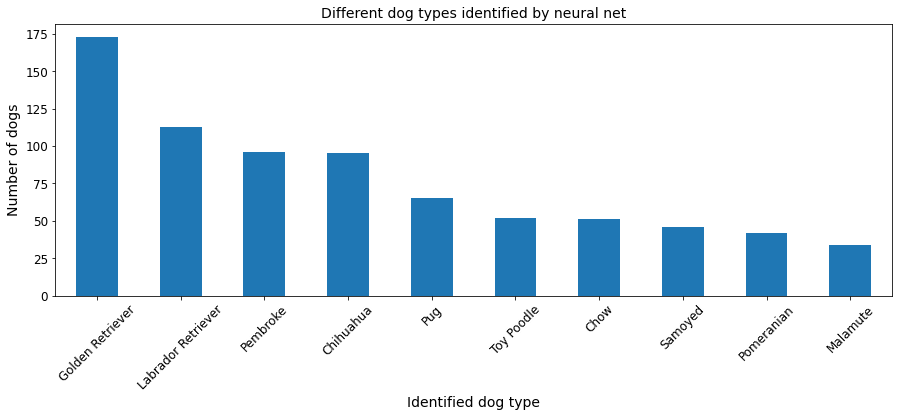

In [90]:
all_dogs_concat.value_counts()[0:10].plot(kind='bar', figsize = (15,5)); 
plt.xlabel('Identified dog type', fontsize = 14)
plt.ylabel('Number of dogs', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Different dog types identified by neural net', fontsize = 14);

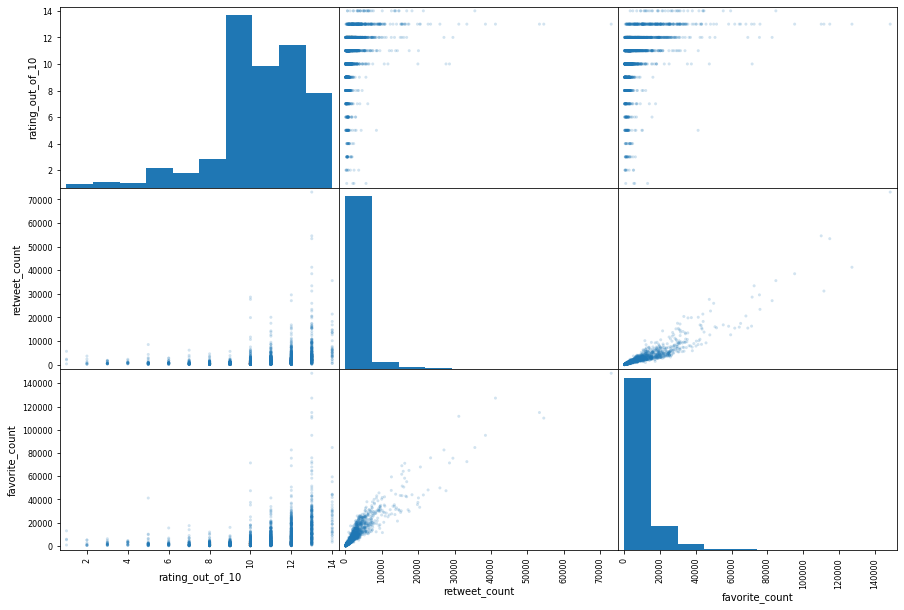

In [91]:
# Overview of important variable in the master dataframe
df = master_df[['rating_out_of_10', 'retweet_count', 'favorite_count']]
pd.plotting.scatter_matrix(df, figsize = (15,10), alpha=0.2);

In [92]:
ratings_dogs = pd.DataFrame(df['rating_out_of_10'].value_counts())
ratings_dogs.reset_index(level = 0, inplace = True)
ratings_dogs.rename(columns = {"index":"Rating", "rating_out_of_10":"Number of dogs"}, inplace = True)
ratings_dogs = ratings_dogs.sort_values(by = "Rating")

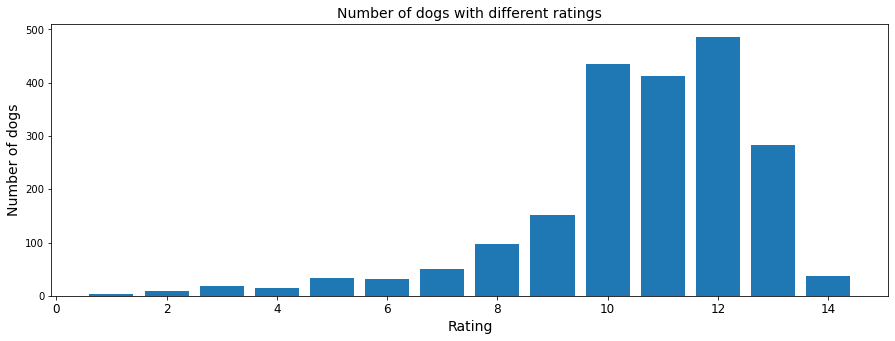

In [93]:
plt.figure(figsize = (15,5))
plt.bar(ratings_dogs.Rating, ratings_dogs['Number of dogs'])
plt.ylabel('Number of dogs', fontsize = 14)
plt.xlabel('Rating', fontsize = 14);
plt.xticks(fontsize = 12)
plt.title('Number of dogs with different ratings', fontsize = 14);

Most dogs received scores of 10, 11 and 12. 

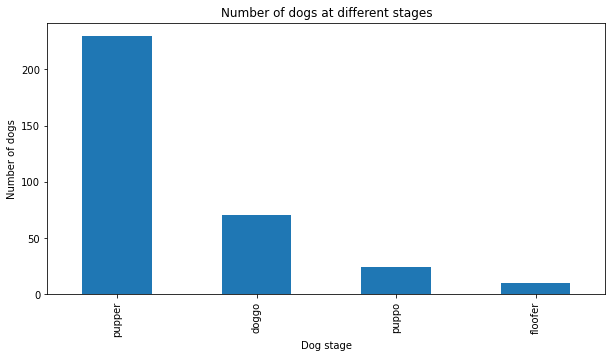

In [94]:
df = master_df.copy()
df['stage'].value_counts()[1:].plot(kind='bar', figsize = (10,5)); # Ignoring "Not recorded"
plt.xlabel('Dog stage')
plt.ylabel('Number of dogs')
plt.title('Number of dogs at different stages');

The most assigned stage is the "pupper". This is probably not that useful as most of the dogs don't have an assigned stage:

In [95]:
df['stage'].value_counts()

Not recorded    1734
pupper           230
doggo             71
puppo             24
floofer           10
Name: stage, dtype: int64

In [96]:
df['name'].value_counts()[0:5] 

None       589
a           54
Oliver      10
Charlie     10
Lucy        10
Name: name, dtype: int64

"None" & "a" are not correct names; we will not clean these on this occassion as we are not greatly interested in the name in this particular analysis. We can have a quick look though... 

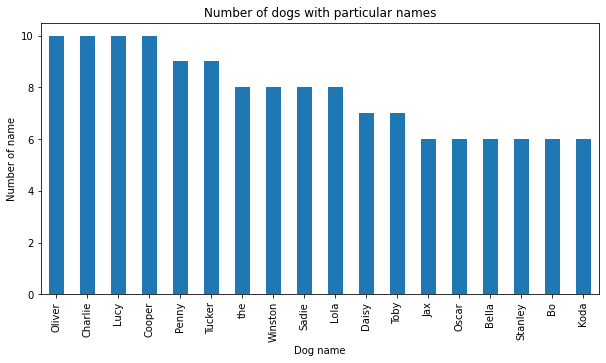

In [97]:
df['name'].value_counts()[2:20].plot(kind='bar', figsize = (10,5)); 
plt.xlabel('Dog name')
plt.ylabel('Number of name')
plt.title('Number of dogs with particular names');

We should do a spot check to make sure that these are different dogs. Manually inspecting the images reveals that the dogs are indeed different. So here we learn that common names for dogs are "Lucy", "Charlie", "Oliver" and "Copper". 

As "None" & "a" are not correct names, there may well be names which are more common than "Lucy", "Charlie", "Oliver" and "Copper" so these should *not* be thought of as the top four names.

In [98]:
 def regression_plot(x, y, data, xlabel = "", ylabel = "", title = "", xlim = (0,10), ylim = (0,1000)):
    '''This function is used to plot the dependent variable against the independent variable.'''       
    plt.figure(figsize = (10,6))
    ax = sns.regplot(x=x, y=y, data=data, marker="+", scatter_kws={'alpha':0.3})
    plt.xlabel(xlabel, labelpad=14, fontsize = 14);
    plt.ylabel(ylabel, labelpad=14, fontsize = 14);
    plt.title(title, fontsize = 14);
    plt.xticks(fontsize = 14)
    plt.xlim(xlim[0],xlim[1]); plt.ylim(ylim[0],ylim[1]);

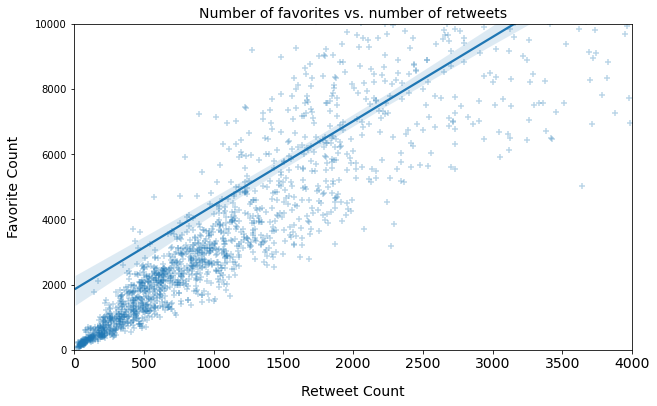

In [99]:
regression_plot(x="retweet_count", y="favorite_count", data=master_df, xlabel = 'Retweet Count', ylabel = 'Favorite Count', title = "Number of favorites vs. number of retweets", xlim = (0,4000), ylim = (0,10000))

More retweeted tweets are also the more favorited tweets.

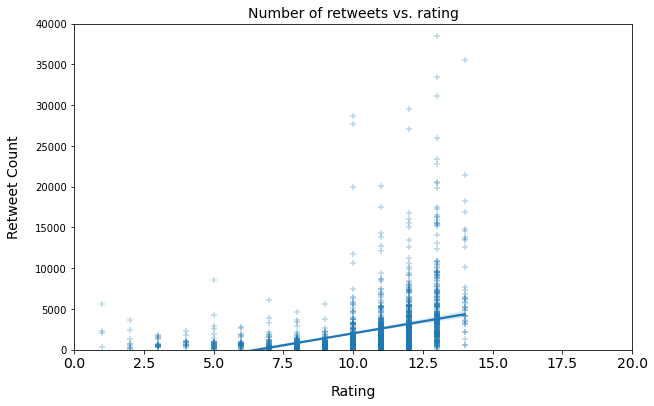

In [100]:
regression_plot(x="rating_out_of_10", y="retweet_count", data=master_df, xlabel = 'Rating', ylabel = 'Retweet Count', title = "Number of retweets vs. rating", xlim = (0,20), ylim = (0,40000))

The higher the rating of the dog, the more likely the associated tweet is to be retweeted.

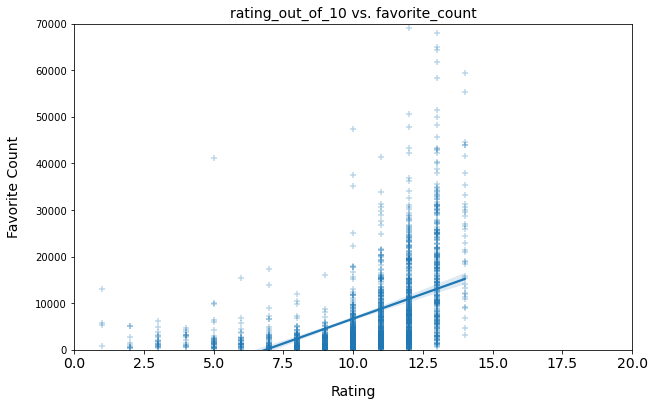

In [101]:
regression_plot(x="rating_out_of_10", y="favorite_count", data=master_df, xlabel = 'Rating', ylabel = 'Favorite Count', title = "rating_out_of_10 vs. favorite_count", xlim = (0,20), ylim = (0,70000))

The higher the rating of the dog, the more likely it is to be favorited (or "liked") on twitter.

Let us see if we can devise a model that predicts favorite count from the retweet count.

In [102]:
df['intercept'] = 1
lm = sm.OLS(df['favorite_count'], df[['intercept', 'retweet_count']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 1.238e+04
Date:                Sat, 17 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:26:51   Log-Likelihood:                -20292.
No. Observations:                2069   AIC:                         4.059e+04
Df Residuals:                    2067   BIC:                         4.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1846.0992    111.292     16.588      0.000    1627.843    2064.355
retweet_count     2.5818      0.023    111.261      0.000       2.536       2.627
==============================================================================
Omnibus:                      560.254   Durbin-Watson:                   0.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13390.624
Skew:                           0.710   Prob(JB):                         0.00
Kurtosis:                      15.382   Cond. No.                     5.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p values are less than 0.5 for the intercept and the gradient so these are statistically significant results.

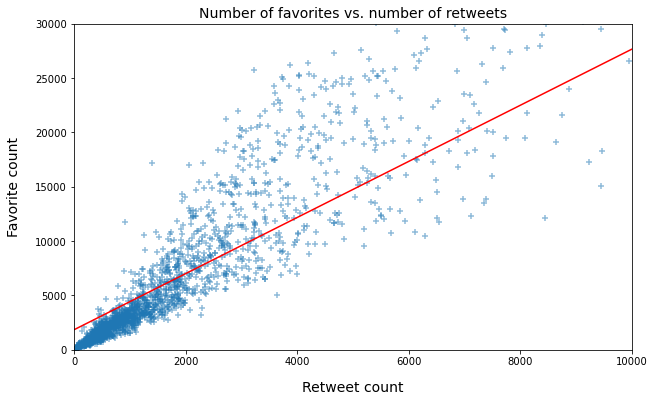

In [103]:
intercept, gradient = results.params[0], results.params[1]

x = master_df.retweet_count
y = master_df.favorite_count
xlabel, ylabel, title = "Retweet count", "Favorite count", "Number of favorites vs. number of retweets"

fit_x = np.linspace(start = x.min(), stop = x.max(), num = 2) # Only two points are needed to fit a straight line
fit_y = (gradient*fit_x) + intercept # Create a linear regression line

plt.figure(figsize = (10,6))
plt.scatter(x, y, marker="+", alpha = 0.5)
plt.plot(fit_x, fit_y, color = 'red')
plt.xlabel(xlabel, labelpad=14, fontsize = 14);
plt.ylabel(ylabel, labelpad=14, fontsize = 14);
plt.title(title, fontsize = 14);
plt.xlim(0,10000); plt.ylim(0,30000)
plt.show()

Let us see if we can also devise a model that predicts favorite count from the rating.

In [104]:
df['intercept'] = 1
lm = sm.OLS(df['favorite_count'], df[['intercept', 'rating_out_of_10']])
results = lm.fit()
print(results.params)
results.summary()

intercept          -14616.651313
rating_out_of_10     2129.935595
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     376.2
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           3.99e-77
Time:                        11:26:51   Log-Likelihood:                -22130.
No. Observations:                2069   AIC:                         4.426e+04
Df Residuals:                    2067   BIC:                         4.428e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept        -1.462e+04   1188.321    -12.300      0.000   -1.69e+04   -1.23e+04
rating_out_of_10  2129.9356    109.816     19.395      0.000    1914.574    2345.297
==============================================================================
Omnibus:                     2025.374   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121275.318
Skew:                           4.618   Prob(JB):                         0.00
Kurtosis:                      39.352   Cond. No.                         55.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

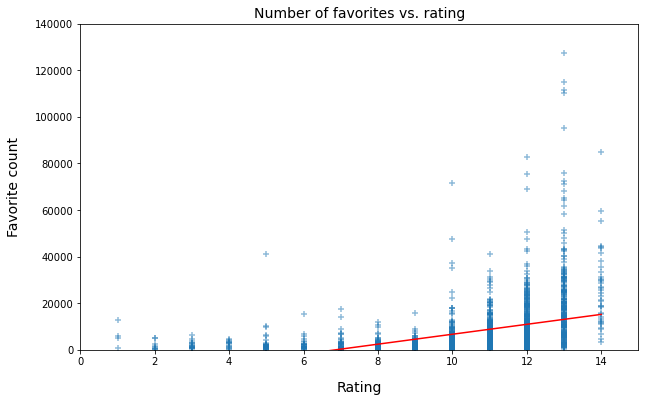

In [105]:
intercept, gradient = results.params[0], results.params[1]
x = master_df.rating_out_of_10
y = master_df.favorite_count
xlabel, ylabel, title = "Rating", "Favorite count", "Number of favorites vs. rating"

fit_x = np.linspace(start = x.min(), stop = x.max(), num = 2) # Only two points are needed to fit a straight line
fit_y = (gradient*fit_x) + intercept # Create a linear regression line

plt.figure(figsize = (10,6))
plt.scatter(x, y, marker="+", alpha = 0.5)
plt.plot(fit_x, fit_y, color = 'red')
plt.xlabel(xlabel, labelpad=14, fontsize = 14);
plt.ylabel(ylabel, labelpad=14, fontsize = 14);
plt.title(title, fontsize = 14);
plt.ylim(0,140000)
plt.xlim(0,15)
plt.show()

The p values are less than 0.5 for the intercept and the gradient so these are statistically significant results. The R-squared value is only 0.154 so although there is a positive correlation here it is weak.

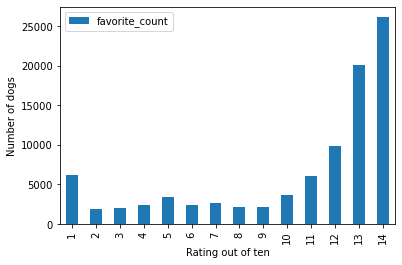

In [106]:
#master_df[['rating_out_of_10','favorite_count']].groupby('rating_out_of_10').mean()
master_df[['rating_out_of_10','favorite_count']].groupby('rating_out_of_10').mean().plot(kind = 'bar');
plt.ylabel('Number of dogs')
plt.xlabel('Rating out of ten');

The more highly the dog is rated, the more likely it is that it will be "liked" by a twitter user.

# References

Wickham, H. (2014). Tiday Data. Journal of Statistical Software, 59(10), 1–23. http://www.jstatsoft.org/